              Time   Sym   C/P        Exp  Strike   Spot  BidAsk  Orders  \
0  6/17/2022 15:07  ISEE  Call 2022-10-21    10.0   9.54    5.05       7   
1  6/17/2022 15:05  CVNA  Call 2024-01-19    60.0  23.52    4.60       7   
2  6/17/2022 14:51  PTLO   Put 2023-02-17    15.0  15.19    3.50       7   
3  6/17/2022 14:39  TWLO  Call 2022-06-24    86.0  84.51    2.95       5   
4  6/17/2022 13:56  ATUS   Put 2022-09-16     7.0   8.62    0.68       5   

     Vol    Prems     OI  Diff(%)  ITM  
0    360  183.60K  4.07K     4.71    0  
1    634  310.66K    130   155.05    0  
2    800  281.00K      0     1.39    0  
3    722  198.80K    436     2.48    0  
4  6.27K  501.84K  8.63K    23.13    0  


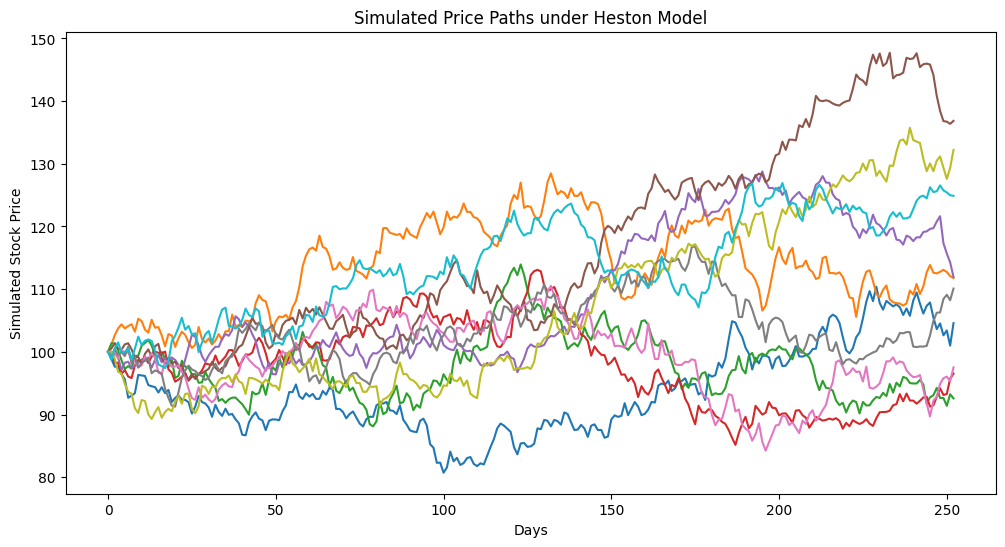

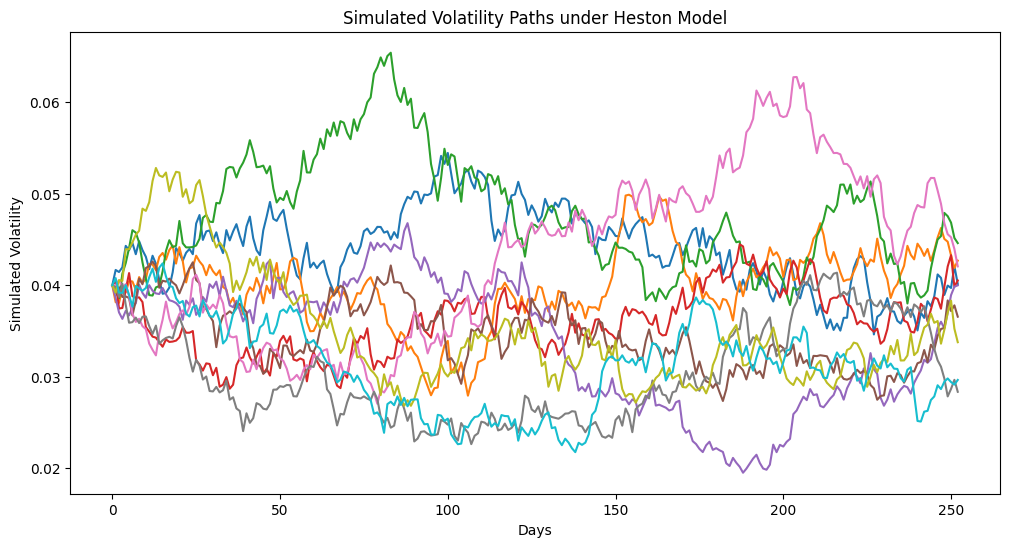

,Time,Sym,C/P,Exp,Strike,Spot,BidAsk,Orders,Vol,Prems,OI,Diff(%),ITM,modeled_price
0,6/17/2022 15:07,ISEE,Call,2022-10-21,10.0,9.54,5.05,7,360,183.60K,4.07K,4.71,0,90.603119
1,6/17/2022 15:05,CVNA,Call,2024-01-19,60.0,23.52,4.60,7,634,310.66K,130,155.05,0,43.069263
2,6/17/2022 14:51,PTLO,Put,2023-02-17,15.0,15.19,3.50,7,800,281.00K,0,1.39,0,85.846972
3,6/17/2022 14:39,TWLO,Call,2022-06-24,86.0,84.51,2.95,5,722,198.80K,436,2.48,0,19.945606
4,6/17/2022 13:56,ATUS,Put,2022-09-16,7.0,8.62,0.68,5,6.27K,501.84K,8.63K,23.13,0,93.456807


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

df = pd.read_csv('../data/raw/trade_flow.csv')
df.head()
df['Exp'] = pd.to_datetime(df['Exp']) # Convert expiration dates to datetime format
print(df.head())

# stochastic volatility model
def heston_model(S0, V0, r, kappa, theta, xi, rho, T, N, M):
    """
    Simulate the Heston Stochastic Volatility Model using Monte Carlo. Got all the variable info off of online... not sure if accurate or not
    S0: Initial stock price
    V0: Initial variance
    r: Risk-free rate
    kappa: Mean reversion speed = how quickly volatility returns to normal
    theta: Long-run variance = avg volatility over time
    xi: Volatility of volatility = how much volatility fluctuates
    rho: Correlation between asset and volatility
    T: Time to maturity
    N: Number of time steps
    M: Number of simulations
    """
    dt = T / N  # Time step
    S = np.zeros((N+1, M))  # Store simulated price paths
    V = np.zeros((N+1, M))  # Store simulated variance paths
    
    # S and V initialized and set to 0
    S[0, :] = S0
    V[0, :] = V0

    # Simulate paths (got the formulas from online... not sure if very accurate or not)
    for t in range(1, N+1):
        Z1 = np.random.normal(0, 1, M)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(0, 1, M)
        
        # Update variance
        V[t, :] = np.maximum(0, V[t-1, :] + kappa * (theta - V[t-1, :]) * dt + xi * np.sqrt(V[t-1, :]) * np.sqrt(dt) * Z2)

        # Update price
        S[t, :] = S[t-1, :] * np.exp((r - 0.5 * V[t-1, :]) * dt + np.sqrt(V[t-1, :]) * np.sqrt(dt) * Z1)

    return S, V

# Example Parameters
S0 = 100     # Initial stock price
V0 = 0.04    # Initial variance
r = 0.05     # Risk-free rate
kappa = 2.0  # Mean reversion speed
theta = 0.04 # Long-run variance
xi = 0.1     # Volatility of volatility
rho = -0.5   # Correlation between stock and volatility
T = 1        # 1-year maturity
N = 252      # 252 trading days
M = 10000    # 10,000 simulations

# Run simulation
S_sim, V_sim = heston_model(S0, V0, r, kappa, theta, xi, rho, T, N, M)

plt.figure(figsize=(12, 6))
plt.plot(S_sim[:, :10])  # Plot sample price paths
plt.xlabel("Days")
plt.ylabel("Simulated Stock Price")
plt.title("Simulated Price Paths")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(V_sim[:, :10])  # Plot sample volatility paths
plt.xlabel("Days")
plt.ylabel("Simulated Volatility")
plt.title("Simulated Volatility Paths")
plt.show()

# price options under the simulated path
def price_options(S_sim, strike_price, r, T):
    payoff = np.maximum(S_sim[-1, :] - strike_price, 0)  # Call  payoff
    return np.exp(-r * T) * np.mean(payoff)  #  expected payoff

df['modeled_price'] = df.apply(lambda row: price_options(S_sim, row['Strike'], r, T), axis=1)
df.head()
